In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [4]:
import pandas as pd

In [6]:
test_data=pd.read_csv("test.csv",header=0)
test_data.head()
test_data.info()

train_data=pd.read_csv("train.csv",header=0)
train_data.head()
train_data.info()

,label,text
0,2,This is a little longer and more detailed than...
1,1,Only Michelle Branch save this album!!!!All gu...
2,2,"A surprisingly good book, given its inherently..."
3,2,"This is a wonderful, quiet and relaxing CD tha..."
4,1,The lights that I received are absolutely not ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 2 columns):
label    201 non-null int64
text     201 non-null object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


,label,text
0,1,Unfortunately I had to return the Blue Ant bec...
1,2,...but a very good pick anyway! As usual Don C...
2,2,"Bayard is not Dickens, but his characters and ..."
3,1,I'm used to better quality mysteries.....just ...
4,2,"To Pearl Jam Lion, I really don't appreciate b..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
label    500 non-null int64
text     500 non-null object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

parameters = {'tfidf__min_df':[1, 2, 5],
              'tfidf__stop_words':[None,"english"],
              'clf__alpha': [0.5, 1.0, 2, 3, 4]}

metric =  "f1_macro"

gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)

gs_clf = gs_clf.fit(train_data["text"], train_data["label"])


In [15]:
for param_name in gs_clf.best_params_:
    print("{} : {}".format(param_name , gs_clf.best_params_[param_name]))
print("best f1 score:", gs_clf.best_score_)

clf_alpha = gs_clf.best_params_["clf__alpha"]
tfidf_min_df = gs_clf.best_params_["tfidf__min_df"]
tfidf_stop_words = gs_clf.best_params_["tfidf__stop_words"]



clf__alpha : 3
tfidf__min_df : 5
tfidf__stop_words : english
best f1 score: 0.7151911246709968


In [61]:
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=tfidf_stop_words,\
                              min_df=tfidf_min_df)),
    ('clf', MultinomialNB(alpha = clf_alpha ))])

clf = classifier.fit(train_data["text"],  train_data["label"])

In [62]:
from sklearn.metrics import classification_report

labels=sorted(train_data["label"].unique())
labels = list(map(str, labels))

predicted = classifier.predict(test_data["text"])


print(classification_report(test_data["label"], predicted, target_names=labels))

              precision    recall  f1-score   support

           1       0.70      0.73      0.71        99
           2       0.72      0.70      0.71       102

   micro avg       0.71      0.71      0.71       201
   macro avg       0.71      0.71      0.71       201
weighted avg       0.71      0.71      0.71       201



In [70]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve
import numpy as np

predict_p = clf.predict_proba(test_data["text"])
y_pred = predict_p[:,1]

binary_y = np.where(test_data["label"] ==2 ,1 ,0)

fpr, tpr, thresholds = roc_curve(binary_y, y_pred, pos_label=1)

In [87]:
clf

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...=True,
        vocabulary=None)), ('clf', MultinomialNB(alpha=3, class_prior=None, fit_prior=True))])

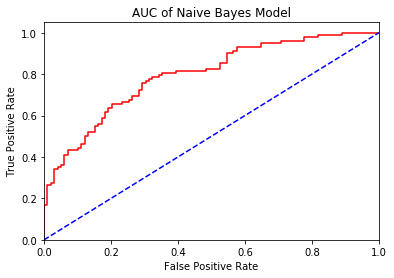

In [82]:
from matplotlib import pyplot as plt

plt.figure();
plt.plot(fpr, tpr, color='red');
plt.plot([0, 1], [0, 1], color='blue', linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Naive Bayes Model');
plt.show();

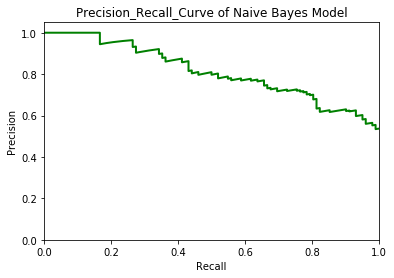

In [83]:
precision, recall, thresholds = precision_recall_curve(binary_y, y_pred, pos_label=1)

plt.figure();
plt.plot(recall, precision, color='green', lw=2);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision_Recall_Curve of Naive Bayes Model');
plt.show();

In [86]:
print( "AUC = {}".format(auc(fpr, tpr)))

AUC = 0.7947118241235889
